In [10]:
import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import style
from pandas import Series, DataFrame
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate

In [11]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()

df = web.DataReader("AAPL", 'yahoo', start, end)

close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

In [12]:
# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(8, 7))

# Adjusting the style of matplotlib
style.use('ggplot')

rets = close_px / close_px.shift(1) - 1

# close_px.pct_change().head()

dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',
                               start=start,
                               end=end)['Adj Close']

retscomp = dfcomp.pct_change()

corr = retscomp.corr()

dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [13]:
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

In [14]:
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [15]:
"""Build the model"""

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)


# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2);

In [16]:
"""Test the model"""

confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)

# Printing the forecast; poly3 seemed most accurate.
forecast_set = clfpoly3.predict(X_lately)
dfreg['Forecast'] = np.nan

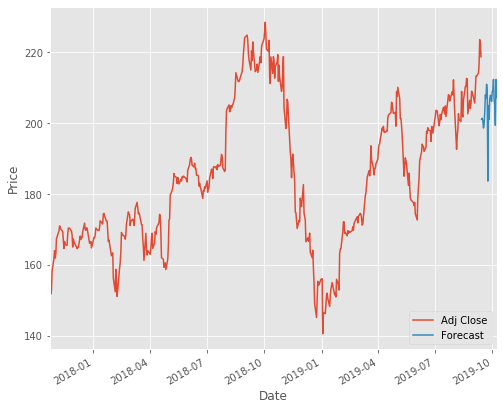

In [17]:
"""Plotting the Prediction"""

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()